Inspired from: https://www.geeksforgeeks.org/q-learning-in-python/

In [1]:
import gym
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys


from collections import defaultdict
import plotting

matplotlib.style.use('ggplot')

In [2]:
#from IPython.core.debugger import set_trace

In [3]:
# Epsilon greedy policy

def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
    
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array 
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
        
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions 
        
        best_action = np.argmax(Q[tuple(state)]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
    
    return policyFunction 

In [4]:
def round_observation(obs):
    """
    The Observation-Space is huge, so we have to round the observed state
    """
    
    for item in range(len(obs)):
        obs[item] = round(obs[item],1)
    
    return obs

In [5]:
# Q-Learning Algorithm

def qLearning(env,
              num_episodes,
              discount_factor = 1.0,
              alpha = 0.6,
              epsilon = 0.1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy
    """
    
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 

    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats(episode_lengths = np.zeros(num_episodes),
                                  episode_rewards = np.zeros(num_episodes))
    
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q,
                                       epsilon,
                                       env.action_space.n) 
    
    # For every episode 
    for ith_episode in range(num_episodes): 
        
        # Reset the environment and pick the first action 
        state = env.reset() 
        
        for t in itertools.count(): 
            
            # Cut the observation down to reduce complexity
            state = round_observation(state)
            
            # get probabilities of all actions from current state 
            action_probabilities = policy(state) 
            
            # choose action according to 
            # the probability distribution 
            action = np.random.choice(
                np.arange(
                    len(action_probabilities)
                ),
                p = action_probabilities
            ) 

            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action) 
            next_state = round_observation(next_state)
            
            # Update statistics 
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            
            # TD Update 
            best_next_action = np.argmax(Q[tuple(next_state)])
            td_target = reward + discount_factor * Q[tuple(next_state)][best_next_action]
            td_delta = td_target - Q[tuple(state)][action]
            Q[tuple(state)][action] += alpha * td_delta

            # done is True if episode terminated
            if done:
                break
                
            state = next_state 
    
    return Q, stats 

In [6]:
# set up environment
env = gym.make('CartPole-v0')

In [7]:
# train the model
Qs, stats = qLearning(env, 5000)

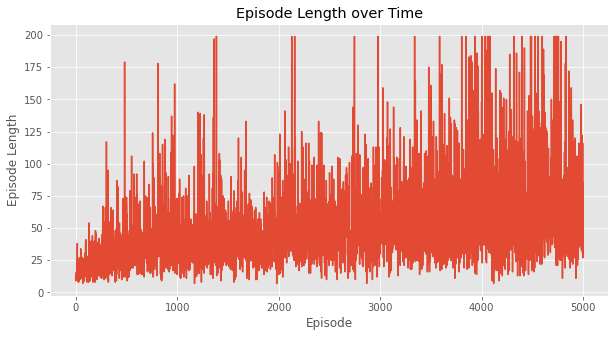

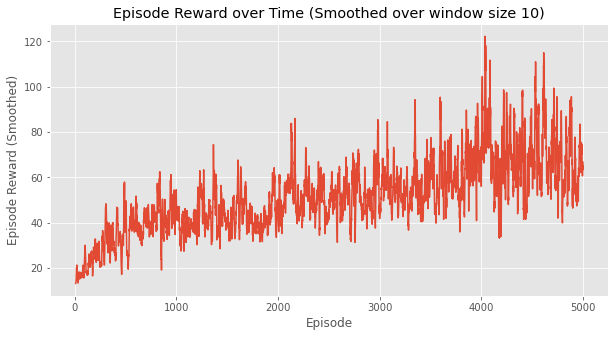

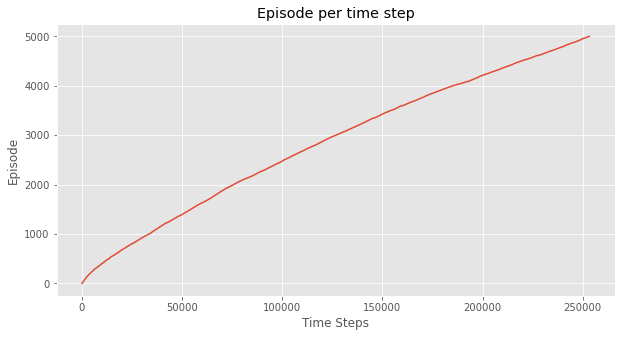

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
# Plot stats
plotting.plot_episode_stats(stats) 

In [9]:
# show how the trained agent behaves

policy = createEpsilonGreedyPolicy(Qs,0.05,env.action_space.n)

for episode in range(10):
    # Reset the environment and pick the first action 
    state = env.reset() 
    
    for t in itertools.count(): 
        env.render()
        # Cut the observation down to reduce complexity
        state = round_observation(state)
        
        # get probabilities of all actions from current state 
        action_probabilities = policy(state) 
        
        # choose action according to 
        # the probability distribution 
        action = np.random.choice(np.arange(len(action_probabilities)),p = action_probabilities) 

        # take action and get reward, transit to next state 
        state, reward, done, _ = env.step(action) 
        
        if done:
            break
env.close()